# 0 - Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.naive_bayes import GaussianNB
from scipy.spatial import distance
from utils import index_sequence_to_string, multi_hot_to_text, render_history, compare_histories, decode

# 1 - Dataset

## 1.1 - Download

In [3]:
dataset, info = tfds.load(
    'imdb_reviews/plain_text',
    split=['train[:80%]','train[80%:]','test'],
    as_supervised=True,
    with_info=True
)
dataset_train_original = dataset[0]
dataset_validate_original = dataset[1]
dataset_test_original = dataset[2]
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0QQDNM/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0QQDNM/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0QQDNM/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpis4_jdk1tfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

## 1.2 - Quick look

In [4]:
for X, y in dataset_train_original.take(8):
  print(X.numpy().decode("utf-8"))
  print(y.numpy())
  print("")

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0

I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was c

## 1.3 - Statistical Exploration

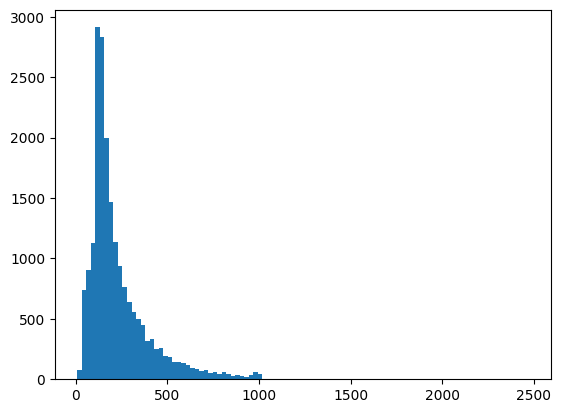

In [5]:
lengths=[]

for X, _ in tfds.as_numpy(dataset_train_original):
  text = X.decode("utf-8").split()
  lengths.append(len(text))



plt.hist(lengths, bins=100)
plt.show()
plt.close()

In [6]:
print("Mean", np.mean(lengths))
print("Min", np.min(lengths))
print("Max", np.max(lengths))

Mean 233.912
Min 10
Max 2470


(array([10031.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  9969.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

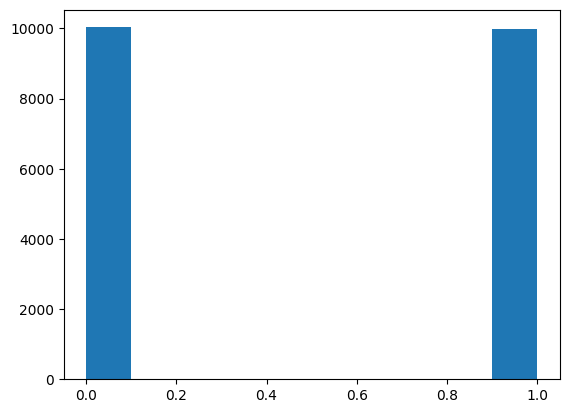

In [7]:
labels = []
for _, y in tfds.as_numpy(dataset_train_original):
  labels += [y]
plt.hist(labels)


# 2 - Encoder: Bag of words encoding

In [8]:
vocab_size = 5000

encoder = layers.TextVectorization(
    max_tokens = vocab_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode = "multi_hot"
)
encoder.adapt(
    dataset_train_original.map(lambda text, label: text).batch(2048)
)



In [9]:
vocabulary = encoder.get_vocabulary()
", ".join(vocabulary[:-100])

'[UNK], the, and, a, of, to, is, in, it, i, this, that, br, was, as, for, with, movie, but, film, on, not, you, his, are, have, be, he, one, its, at, all, by, an, they, who, from, so, like, her, or, just, about, if, has, out, some, there, what, good, very, when, more, she, my, even, would, up, no, which, time, only, really, story, their, had, were, see, can, me, than, we, much, well, been, get, will, also, do, into, people, other, because, bad, first, great, how, most, him, dont, then, made, movies, make, could, films, way, any, them, after, too, characters, think, watch, two, many, being, character, never, seen, little, plot, love, where, acting, best, did, life, show, know, does, ever, your, better, still, over, these, off, end, say, while, here, scene, man, why, such, scenes, go, should, through, something, im, back, those, doesnt, real, watching, thing, years, though, now, actors, didnt, another, new, nothing, makes, before, actually, work, find, old, going, look, same, funny, few,

In [10]:
text = "Hello, ma man! I am great and not late"
print("Original:", text)

text_encoded = encoder(text).numpy()
print("Encoded:", multi_hot_to_text(text_encoded))


Original: Hello, ma man! I am great and not late
Encoded: 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [11]:
for x,y in dataset_train_original.take(8):
  x_encoded = encoder(x)
  print(x_encoded.numpy())
  print(y.numpy())
  print("")

[1. 1. 1. ... 0. 0. 0.]
0

[1. 1. 1. ... 0. 0. 0.]
0

[1. 1. 1. ... 0. 0. 0.]
0

[1. 1. 1. ... 0. 0. 0.]
1

[1. 1. 1. ... 0. 0. 0.]
1

[1. 1. 1. ... 0. 0. 0.]
1

[1. 1. 1. ... 0. 0. 0.]
0

[1. 1. 1. ... 0. 0. 0.]
0



# 3 - Models

## 3.1 - Naive Bayes

In [12]:
def dataset_to_numpy(dataset):
  x_input = []
  y_output = []
  for x, y in dataset.batch(2048):
    x = encoder(x).numpy()
    x_input.extend(x)
    y_output.extend(y.numpy())

  x_input = np.array(x_input)
  y_output = np.array(y_output)
  return x_input, y_output

x_train, y_train = dataset_to_numpy(dataset_train_original)
x_test, y_test = dataset_to_numpy(dataset_test_original)

In [13]:
x_train[1], y_train[1]

(array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), 0)

In [14]:
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
correct_predictions = (y_test == y_pred).sum()
accuracy = correct_predictions / len(x_test)
print(f"{100*accuracy:.2f} % accuracy on test.")

75.83 % accuracy on test.


# 3.2 Multi-Layer Perceptron.

In [15]:
dataset_train = dataset_train_original.cache().shuffle(25000).batch(128)
dataset_validate = dataset_validate_original.cache().batch(128) # dont shuffle baby

In [16]:

model = models.Sequential()
model.add(encoder)
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

#model.predict(["This is a great movie."])

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = 10,
    validation_data = dataset_validate
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 5000)              0         
 ctorization)                                                    
                                                                 
 dropout (Dropout)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 64)                320064    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 320129 (1.22 MB)
Trainable params: 320129 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

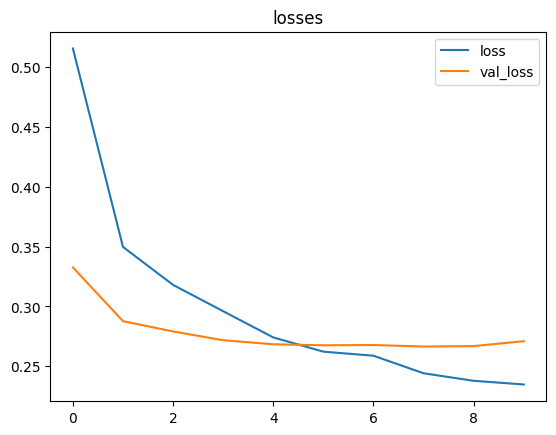

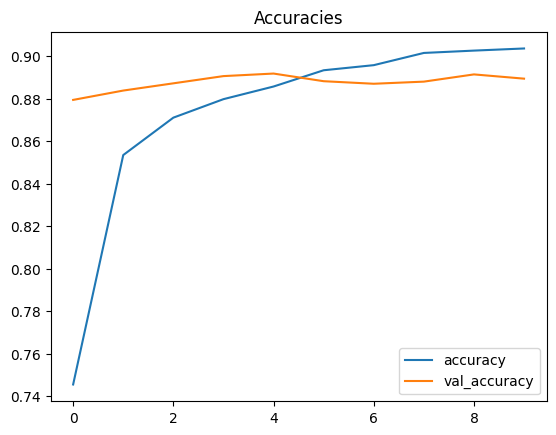

In [17]:
history_list = {}
history_list["Multi-layer Perceptron"] = history.history
render_history(history)

In [18]:
model.evaluate(dataset_test_original.batch(128))

196/196 [==============================] - 2s 12ms/step - loss: 0.2864 - accuracy: 0.8823


[0.28640949726104736, 0.882319986820221]

## 3.2 - Word Embeddings

In [19]:
vocab_size = 10000
sequence_length = 128

encoder = layers.TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length = sequence_length,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    output_mode="int"
)

encoder.adapt(
    dataset_train_original.map(lambda text, label: text).batch(512)
)

In [20]:
encoder.get_vocabulary()[:100]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'his',
 'are',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'so',
 'like',
 'her',
 'or',
 'just',
 'about',
 'if',
 'has',
 'out',
 'some',
 'there',
 'what',
 'good',
 'very',
 'when',
 'more',
 'she',
 'my',
 'even',
 'would',
 'up',
 'no',
 'which',
 'time',
 'only',
 'really',
 'story',
 'their',
 'had',
 'were',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'well',
 'been',
 'get',
 'will',
 'also',
 'do',
 'into',
 'people',
 'other',
 'because',
 'bad',
 'first',
 'great',
 'how',
 'most',
 'him',
 'dont',
 'then',
 'made',
 'movies',
 'make',
 'could',
 'films',
 'way',
 'any',
 'them']

In [21]:
text = "Here is another great example of text, words and bullshizles"
print("Original", text)

text_encoded = encoder(text)
print("Word indices", index_sequence_to_string(text_encoded.numpy()))


text_decoded = decode(encoder,text_encoded)
print("Decoded", text_decoded)

Original Here is another great example of text, words and bullshizles
Word indices 132, 7, 154, 86, 459, 5, 2958, 653, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
Decoded here is another great example of text words and [UNK]                                                                                                                      


In [22]:
for x, y in dataset_train_original.take(8):
  x_encoded = encoder(x).numpy()
  print(x_encoded)
  print(y.numpy())

[  11   14   34  411  376   18   90   27    1    8   33 1322 4160   41
  501    1  193   25   86  152   19   11  216  316   27   65  241  213
    8  485   56   65   86  115   95   22 5688   11   93  635  739   11
   18    7   34  396 9900  169 2483  409    2   88 1205  137   67  144
   52    2    1 7103   67  245   65 2939   16    1 2795    1    1 1441
 5059    3   40    1 1659   17 4160   14  156   19    4 1205  853 7814
    8    4   18   12   14 3839    5   98  146 1222   10  231  683   12
   48   25   93   39   11 7523  152   39 1322    1   50  408   10   95
 1157  845  140    9    0    0    0    0    0    0    0    0    0    0
    0    0]
0
[  10   26   75  622    6  779 2359  297   96   19   11    7  602  670
    6    4 2158    5  181  581   63 1353  107 2308    3 3882   21    2
    1    3  248   42 4729    4  170  189   21   11 4476   10 1512 2359
   83    2   20   14 1855    2  112  963   14 1764 1352  592    3  351
  181  447    6  584   19   17   59 1786    5   49   14 4209   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 128)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 128, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               2097664   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2418177 (9.22 MB)
Trainable params: 2418177 (9.22 MB)
Non-trainable params: 0 (0.00 Byte)
________________

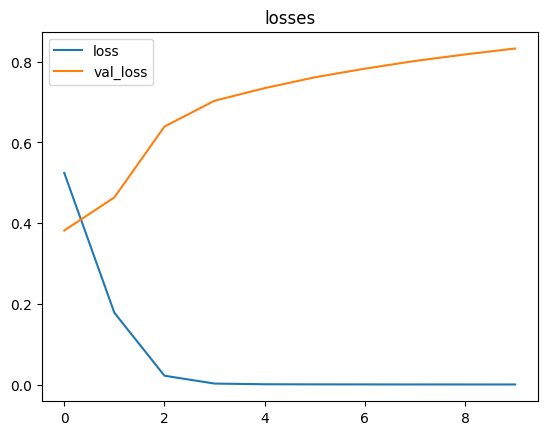

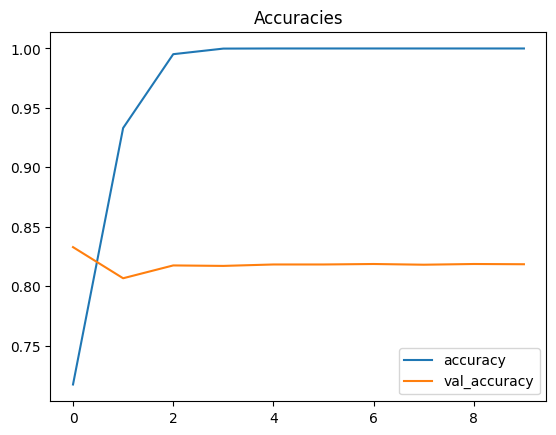

In [23]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocab_size, output_dim=32))
model.add(layers.Flatten())
model.add(layers.Dense(512, "relu"))
model.add(layers.Dense(1, "sigmoid"))
model.summary()

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

history= model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_validate
)

history_list["Word Embeddings"] = history.history
render_history(history)

## 3.3 - LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 128)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 128, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 344897 (1.32 MB)
Trainable params: 344897 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 31s 177ms/step - loss: 0.5465 

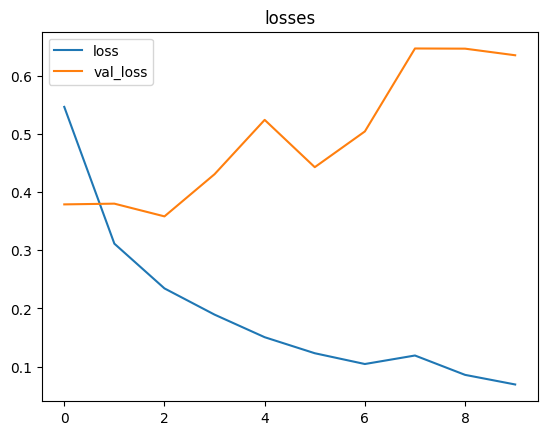

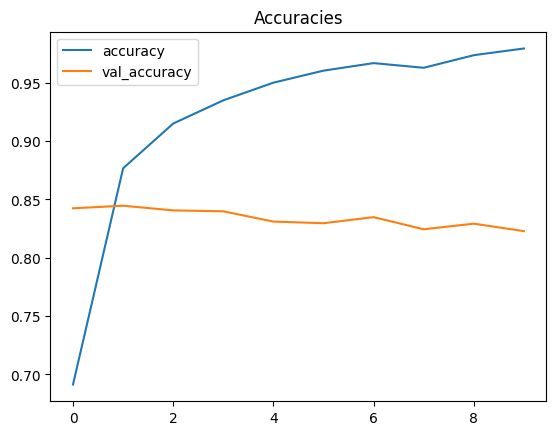

In [25]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocab_size,output_dim=32))
model.add(layers.LSTM(64))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = 10,
    validation_data = dataset_validate
)



history_list["LSTM"] = history.history
render_history(history)

## 3.3 NLP Transformer

In [26]:
from TransformerEncoder import TransformerEncoder

In [27]:
dataset_train = dataset_train_original.map(lambda text, label: (encoder(text), label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(25000)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda text, label: (encoder(text), label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

In [29]:
model = models.Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size, output_dim = 256, input_length = sequence_length)
)
model.add(TransformerEncoder(embed_dim=256, dense_dim=32, num_heads=2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
     dataset_train,
     epochs = 10,
     validation_data = dataset_validate
 )


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 256)          2560000   
                                                                 
 transformer_encoder (Trans  (None, 128, 256)          543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3104033 (11.84 MB)
Trainable params: 310

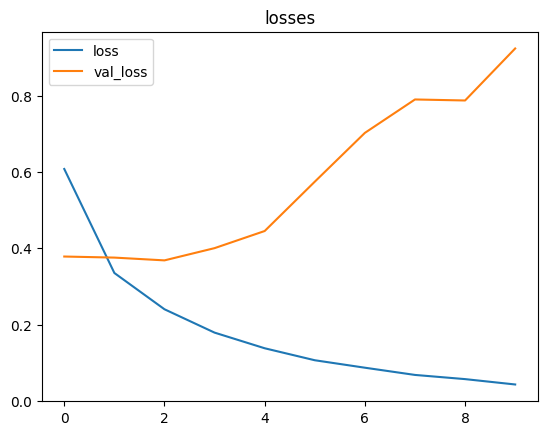

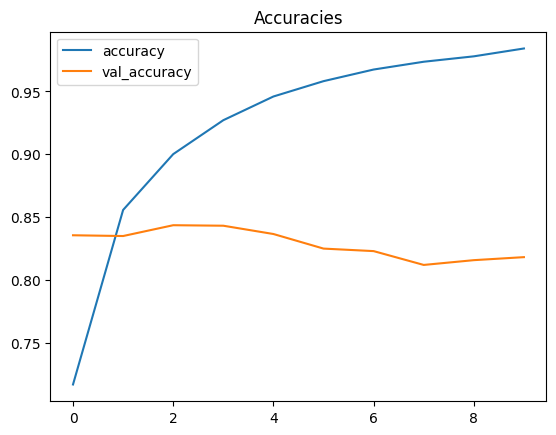

In [30]:
history_list["Transformer"] = history.history
render_history(history)

## 3.4 Transformer with positional embeddings

In [31]:
from PositionalEmbedding import PositionalEmbedding

In [33]:
model = models.Sequential()
model.add(layers.Input(shape=(sequence_length, ), dtype="int64"))
model.add(PositionalEmbedding(
    input_dim=vocab_size, output_dim = 256, sequence_length=sequence_length
)
          )
model.add(TransformerEncoder(embed_dim=256, dense_dim=32, num_heads=2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
     dataset_train,
     epochs = 10,
     validation_data = dataset_validate
 )


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posi  (None, 128, 256)          2592768   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder_1 (Tra  (None, 128, 256)          543776    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                      

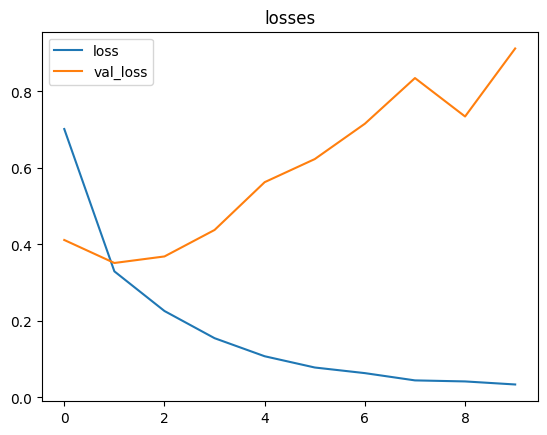

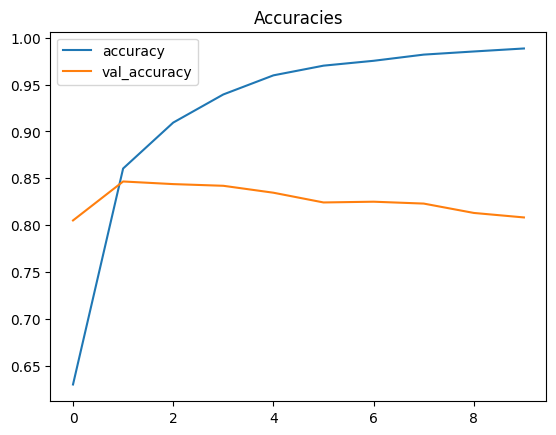

In [34]:
history_list["Transformer_positional_embedding"] = history.history
render_history(history)

# 4 - Results: Validation accuracy per model

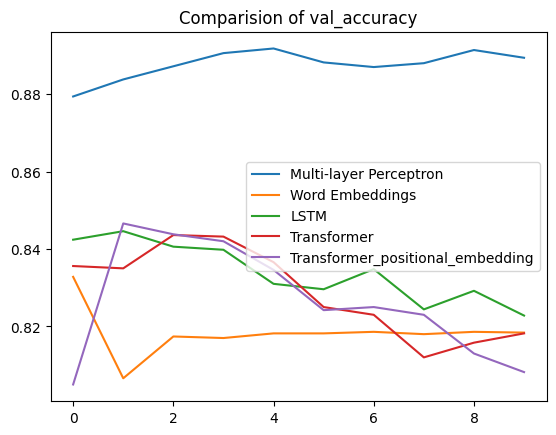

In [35]:
compare_histories(history_list)